In [340]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16
from turtle import shape
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import PIL
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [341]:
data_dir = 'Train'


img_height = 360
img_width = 360
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.


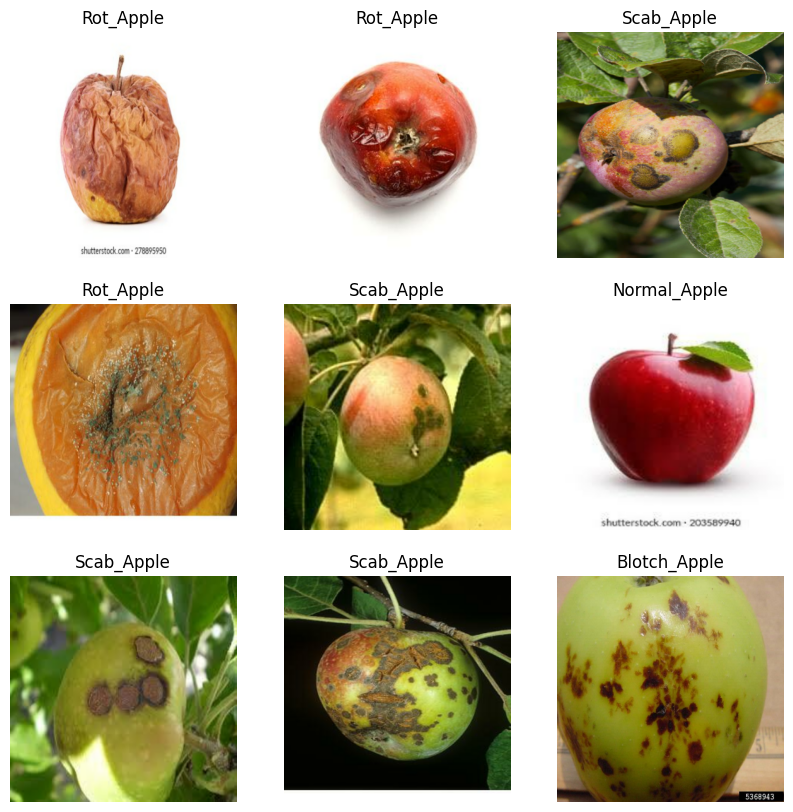

In [342]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    # plt.show()


In [343]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [346]:

#ata_augmentation = keras.Sequential(
#  [
#    layers.RandomFlip("horizontal_and_vertical",
#                      input_shape=(img_height,
#                                  img_width,
#                                  3)),
#    layers.RandomRotation(0.1),
#    layers.RandomZoom(0.1),
#  ]
#)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


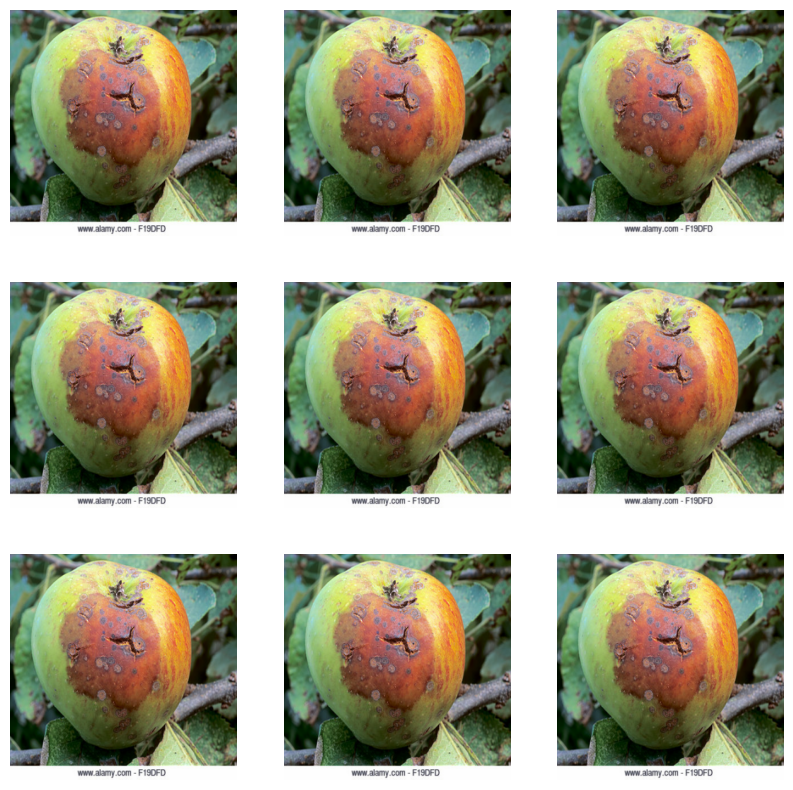

In [347]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [348]:
"""
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
"""

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [349]:
normalization_layer = layers.Rescaling(1./255)

In [273]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [274]:
"""
model = keras.models.Sequential()

model.add(layers.Input(shape=(360, 360, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.1))

model.add(layers.Dense(256))

model.add(layers.Dense(4, activation='softmax'))

model.summary()

num_classes = len(class_names)
"""
"""
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
    ])
"""


model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Input(shape=(360,360,3)),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='softmax'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='relu'),
    ])

model.summary()




"\nmodel = tf.keras.models.Sequential([\n    data_augmentation,\n    tf.keras.layers.Input(shape=(360,360,3)),\n    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='softmax'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.1),\n    tf.keras.layers.Dense(4, activation='relu'),\n    ])\n\nmodel.summary()\n\n"

In [275]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [276]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.5383 - accuracy: 0.3203 - val_loss: 1.3549 - val_accuracy: 0.3816
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 1.3247 - accuracy: 0.4150 - val_loss: 1.2008 - val_accuracy: 0.5395
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 1.2120 - accuracy: 0.4771 - val_loss: 1.1785 - val_accuracy: 0.4342
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 1.0660 - accuracy: 0.5621 - val_loss: 1.0409 - val_accuracy: 0.5395
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 1.0201 - accuracy: 0.5752 - val_loss: 0.8825 - val_accuracy: 0.6184
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.8871 - accuracy: 0.6765 - val_loss: 0.9013 - val_accuracy: 0.6316
Epoch 7/10
10/10 [==============================] - 13s 1s/step - loss: 0.8759 - accuracy: 0.7026 - val_loss: 0.8438 - val_accuracy: 0.6711
Epoch 8/10
10/10 [==

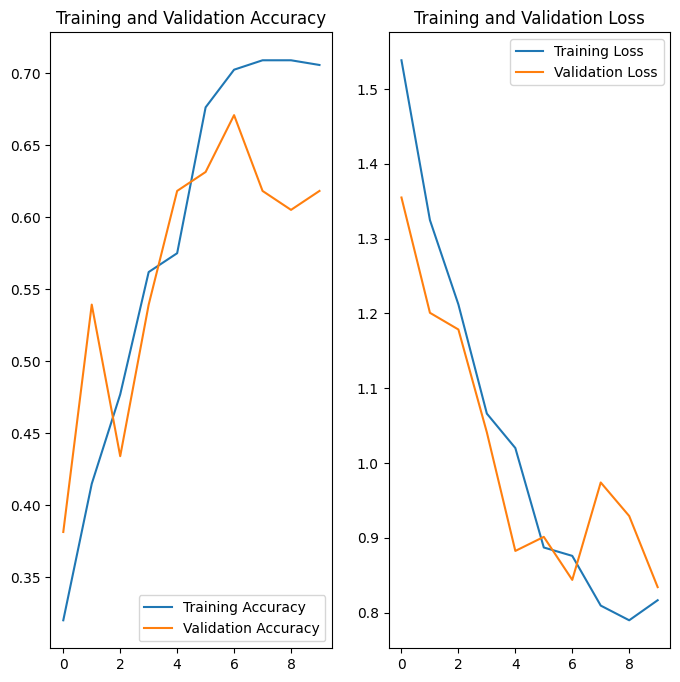

In [277]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()